## Visualize Results with Self-Attention

### Load Pretrained Model

In [41]:
import os
import json
import utils
from model import selfattention as net

MODEL_DIR = "experiments/learning_rate/learning_rate_0.001"
WEIGHT_PATH = os.path.join(MODEL_DIR, "e09.pth.tar")
JSON_PATH = os.path.join(MODEL_DIR, "params.json")
params = utils.Params(JSON_PATH)

model = net.Net(params)
checkpoint = utils.load_checkpoint(WEIGHT_PATH, model)

### Load Text Preprocessing Pipeline

In [42]:
from model.data_loader import DataLoader
DATA_DIR = "data/full_version"
data_loader = DataLoader(DATA_DIR, params)

vocab built


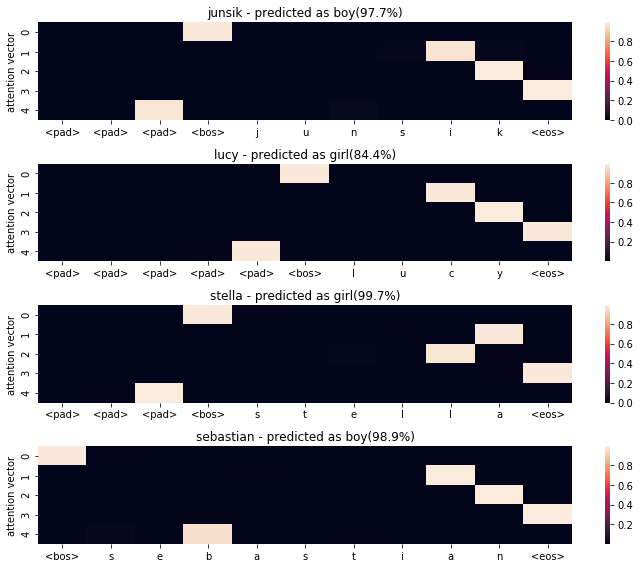

In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

itocls = {
    0: 'girl',
    1: 'boy'
}

def inference(trained_net, test_case):
    trained_net.eval()
    test_case_lower = [case.lower() for case in test_case]
    
    inference_batch = data_loader.BABYNAME.process(test_case_lower, device=torch.device("cpu"))
    bsz, _ = inference_batch.size()
    hidden = trained_net.init_hidden(bsz)
    output, attention, hidden = trained_net(inference_batch, hidden)
    
    return output.detach(), attention.detach(), inference_batch

def visualize_attention(trained_net, test_case):
    
    output, attention, inference_batch = inference(trained_net, test_case)
    
    fig, ax = plt.subplots(len(test_case), figsize=(10, len(test_case) * 2))
    for ix, (case, batch, att) in enumerate(zip(test_case, inference_batch, attention)):
        padded_case = [data_loader.BABYNAME.vocab.itos[ix] for ix in batch]
        sns.heatmap(att.cpu().numpy().T, ax=ax[ix])
        ax[ix].set_xticklabels(padded_case)
        ax[ix].set_ylabel("attention vector")
        sm_output = F.softmax(output, dim=1)
        probability, prediction = sm_output[ix].max(0)
        ax[ix].set_title("{} - predicted as {}({:.1f}%)".format(case, itocls[prediction.item()], probability.item() * 100))
    fig.tight_layout()
    plt.show()
        
test_cases = ['junsik', 'lucy', "stella", "sebastian"]
visualize_attention(model, test_cases)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def run_visualization(trained_net, test_cases, title):
    
    itocls = {
        0: 'girl',
        1: 'boy'
    }

    output, attention, _ = inference(trained_net, test_cases)

    prob, plabel = F.softmax(output, 1).max(1)
    predicted_answers = [itocls[label.item()] for label in plabel]

    normalized_attention_list = []
    for att_ix, att in enumerate(attention):
        case_len = len(test_cases[att_ix])
        summed_attention = att[-(case_len+1):-1, :].sum(1)
        normalized_attention = (summed_attention / summed_attention.sum()).detach().cpu().numpy()
        normalized_attention_list.append(normalized_attention)


    nb_test_cases = len(test_cases)
    
    fig, ax = plt.subplots(nb_test_cases, figsize=(5, nb_test_cases * 0.7))
    for ix, case in enumerate(test_cases):
        ax[ix].text(0, (nb_test_cases-ix) * 0.1, "prediction: {}({}%)".format(predicted_answers[ix], np.round(prob[ix].cpu().numpy() * 100, 1)))
        ax[ix].axis("off")
        for ch_ix, ch in enumerate(case):
            t = ax[ix].text(0.45 + ch_ix * 0.06,(nb_test_cases-ix) * 0.1, ch)
            t.set_bbox(dict(facecolor='red', alpha=normalized_attention_list[ix][ch_ix], edgecolor='red'))

    fig.suptitle(title)
    plt.show()

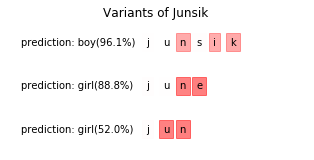

In [45]:
test_cases = ['junsik', 'june', 'jun']
run_visualization(model, test_cases, "Variants of Junsik")

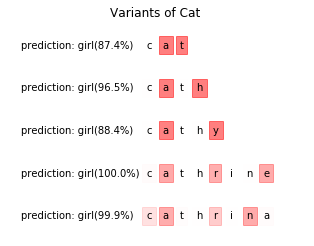

In [5]:
test_cases = ['cat', 'cath', 'cathy', 'cathrine', 'cathrina']
run_visualization(model, test_cases, "Variants of Cat")

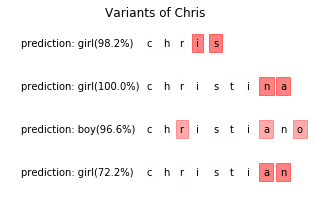

In [6]:
test_cases = ['chris', 'christina', 'christiano', 'christian']
run_visualization(model, test_cases, "Variants of Chris")

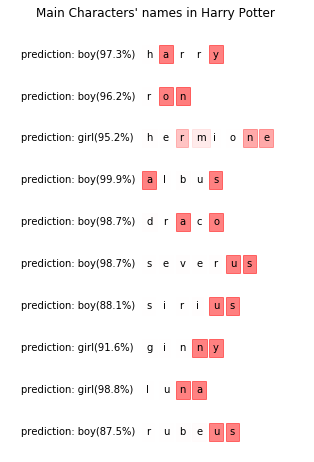

In [7]:
test_cases = ['harry', 'ron', 'hermione', 'albus', 'draco', 'severus', 'sirius', 'ginny', 'luna', 'rubeus']
run_visualization(model, test_cases, "Main Characters' names in Harry Potter")

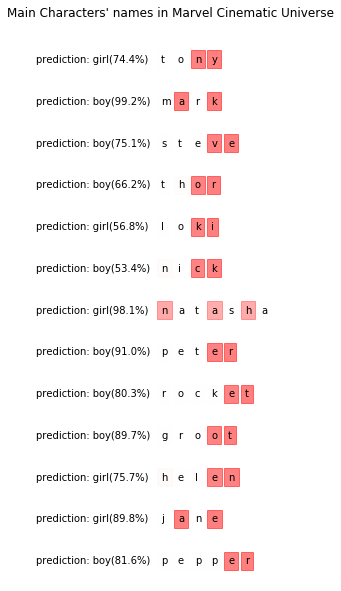

In [8]:
test_cases = ['tony', 'mark', 'steve', 'thor', 'loki', 'nick', 'natasha', 'peter', 'rocket', 'groot', 'helen', 'jane', 'pepper']
run_visualization(model, test_cases, "Main Characters' names in Marvel Cinematic Universe")

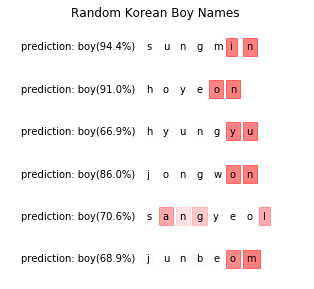

In [9]:
test_cases = ['sungmin', 'hoyeon', 'hyungyu', 'jongwon', 'sangyeol', 'junbeom']
run_visualization(model, test_cases, "Random Korean Boy Names")

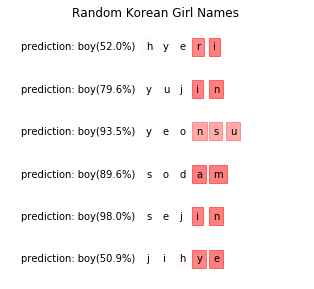

In [10]:
test_cases = ['hyeri', 'yujin', 'yeonsu', 'sodam', 'sejin', 'jihye']
run_visualization(model, test_cases, "Random Korean Girl Names")

## Load Names from Raw Data

In [11]:
import glob

data_path_boy = glob.glob("raw_data/boy_*.csv")
data_path_girl = glob.glob("raw_data/girl_*.csv")

import pandas as pd
boy_df = pd.concat([pd.read_csv(path) for path in data_path_boy])
girl_df = pd.concat([pd.read_csv(path) for path in data_path_girl])
total_df = pd.concat([boy_df, girl_df])

boy_top100 = boy_df[lambda x: x.POPULARITY.notnull()].sort_values(by="POPULARITY").iloc[:100]
girl_top100 = girl_df[lambda x: x.POPULARITY.notnull()].sort_values(by="POPULARITY").iloc[:100]
popular_df = pd.concat([boy_top100, girl_top100]).reset_index(drop=True)

In [12]:
len(popular_df)

200

In [13]:
popular_df.head()

,NAME,ORIGIN,POPULARITY,sex
0,Noah,Hebrew,3.0,boy
1,Liam,German,4.0,boy
2,William,German,7.0,boy
3,Benjamin,Hebrew,11.0,boy
4,Jacob,Hebrew,12.0,boy


In [14]:
len(popular_df)

200

### Extract Embedding

In [15]:
def text2embeddding(trained_model, test_case):

    # to extract H
    outputs_H = []
    def extract_out(self, input, output):
        outputs_H.append(output)
    trained_model.lstm.register_forward_hook(extract_out)

    # prepare inference batch for the test case
    inference_batch = data_loader.BABYNAME.process(test_case, device=torch.device("cpu"))
    
    # run model
    with torch.no_grad():
        trained_model.eval()
        hidden = trained_model.init_hidden(inference_batch.size(0))
        outputs, A, hidden = trained_model.forward(inference_batch, hidden)

        H = outputs_H[0][0]
        M = torch.bmm(H.transpose(1, 2), A)

    return M

test_case = ['Noah']
name_embedding = text2embeddding(model, test_case)
print(name_embedding.size())

name_list = popular_df.NAME.tolist()
BATCH_SIZE = 64
nb_batches = (len(name_list) // BATCH_SIZE) + 1

embedding_result_tmp = []
for ix in range(nb_batches):
    name_batch = name_list[ix*BATCH_SIZE:(ix+1)*BATCH_SIZE]
    embedding = text2embeddding(model, name_batch)
    embedding_result_tmp.append(embedding)
    
embedding_result = torch.cat(embedding_result_tmp)

torch.Size([1, 600, 5])


In [16]:
print(embedding_result.size())

torch.Size([200, 600, 5])


### TSNE Visualization

In [17]:
name_cnt = len(name_list)
embedding_result_flattened = embedding_result.view(name_cnt, -1)

In [18]:
embedding_result_flattened.size()

torch.Size([200, 3000])

In [19]:
import numpy as np
from sklearn.manifold import TSNE
embedding_x = embedding_result_flattened.cpu().numpy()
embedding_tsne = TSNE(n_components=2).fit_transform(embedding_x)
embedding_df = pd.DataFrame(embedding_tsne, columns=['dim0', 'dim1'])

In [20]:
popular_df2 = pd.concat([popular_df, embedding_df], axis=1)

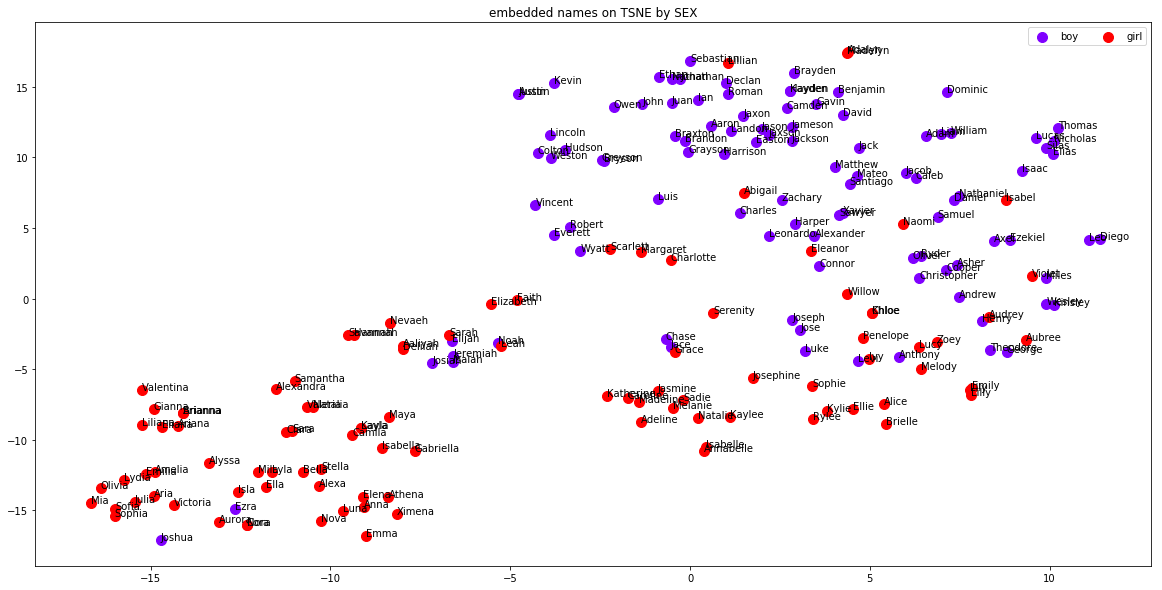

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

origin_dict = {origin:ix for ix, origin in enumerate(popular_df2.sex.unique().tolist())}
colors = cm.rainbow(np.linspace(0, 1, len(popular_df2.sex.unique())))

g = popular_df2.groupby('sex')

fig, ax = plt.subplots(figsize=(20, 10))
for ix, (label, data) in enumerate(g):
    
    color_list = [origin_dict[x] for x in data.sex]
    
    x = data.dim0
    y = data.dim1
    ax.scatter(x, y, c=colors[ix], label=label, cmap='jet', s=100)
    
    for i, txt in enumerate(data.NAME):
        ax.annotate(txt, (x.iloc[i], y.iloc[i]), fontsize=10)

ax.legend(loc='upper right', ncol=3)

plt.title("embedded names on TSNE by SEX")
plt.show()

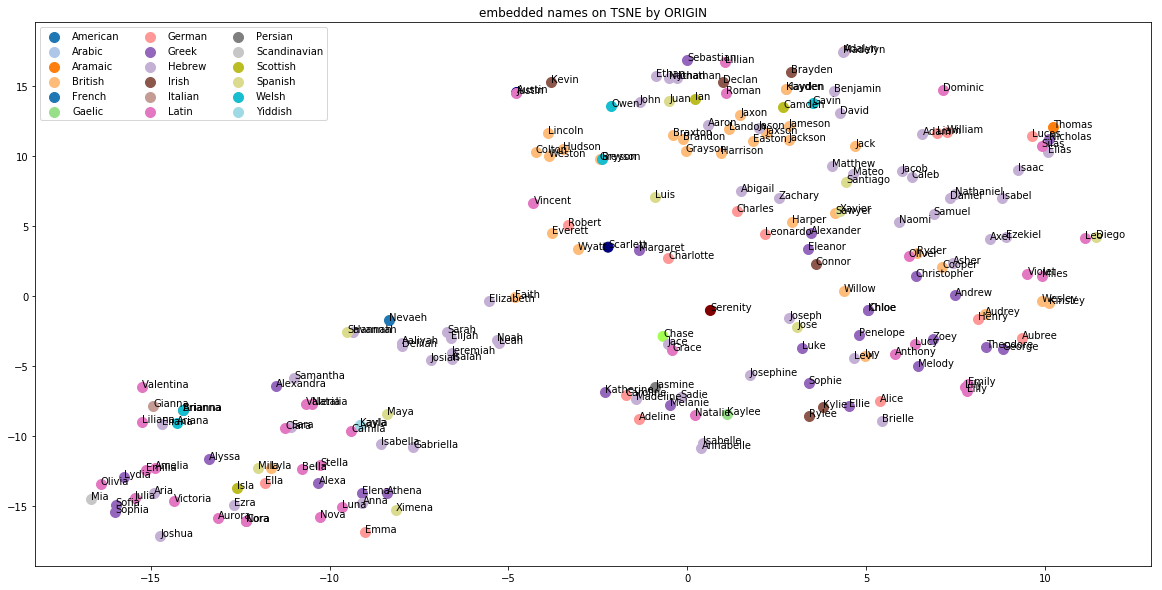

In [22]:
origin_dict = {origin:ix for ix, origin in enumerate(popular_df2.ORIGIN.unique().tolist())}
colors = cm.tab20(np.linspace(0, 1, len(popular_df2.ORIGIN.unique())))

g = popular_df2.groupby('ORIGIN')

fig, ax = plt.subplots(figsize=(20, 10))
for ix, (label, data) in enumerate(g):
    
    color_list = [origin_dict[x] for x in data.ORIGIN]
    
    x = data.dim0
    y = data.dim1
    ax.scatter(x, y, c=colors[ix], label=label, cmap='jet', s=100)
    
    for i, txt in enumerate(data.NAME):
        ax.annotate(txt, (x.iloc[i], y.iloc[i]), fontsize=10)

ax.legend(loc='upper left', ncol=3)

plt.title("embedded names on TSNE by ORIGIN")
plt.show()

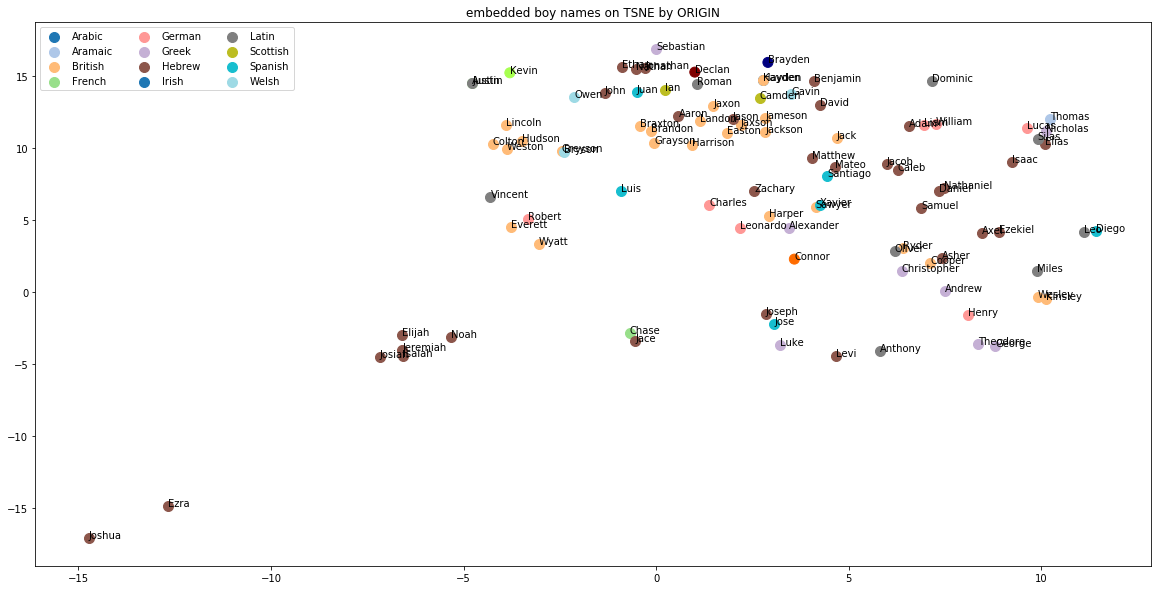

In [23]:
popular_boys_df = popular_df2[lambda x: x.sex == 'boy']

origin_dict = {origin:ix for ix, origin in enumerate(popular_boys_df.ORIGIN.unique().tolist())}
colors = cm.tab20(np.linspace(0, 1, len(popular_boys_df.ORIGIN.unique())))

g = popular_boys_df.groupby('ORIGIN')

fig, ax = plt.subplots(figsize=(20, 10))
for ix, (label, data) in enumerate(g):
    
    color_list = [origin_dict[x] for x in data.ORIGIN]
    
    x = data.dim0
    y = data.dim1
    ax.scatter(x, y, c=colors[ix], label=label, cmap='jet', s=100)
    
    for i, txt in enumerate(data.NAME):
        ax.annotate(txt, (x.iloc[i], y.iloc[i]), fontsize=10)

ax.legend(loc='upper left', ncol=3)

plt.title("embedded boy names on TSNE by ORIGIN")
plt.show()

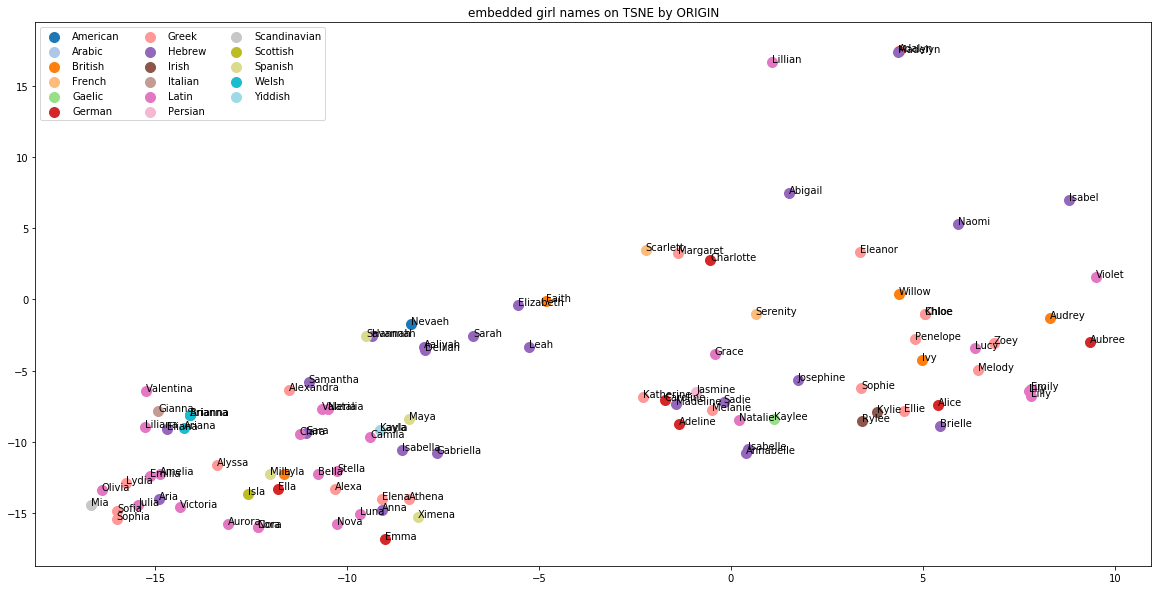

In [24]:
popular_girls_df = popular_df2[lambda x: x.sex == 'girl']

origin_dict = {origin:ix for ix, origin in enumerate(popular_girls_df.ORIGIN.unique().tolist())}
colors = cm.tab20(np.linspace(0, 1, len(popular_girls_df.ORIGIN.unique())))

g = popular_girls_df.groupby('ORIGIN')

fig, ax = plt.subplots(figsize=(20, 10))
for ix, (label, data) in enumerate(g):
    
    color_list = [origin_dict[x] for x in data.ORIGIN]
    
    x = data.dim0
    y = data.dim1
    ax.scatter(x, y, color=colors[ix], label=label, cmap='jet', s=100)
    
    for i, txt in enumerate(data.NAME):
        ax.annotate(txt, (x.iloc[i], y.iloc[i]), fontsize=10)

ax.legend(loc='upper left', ncol=3)

plt.title("embedded girl names on TSNE by ORIGIN")
plt.show()

### Matrix Computation with Names

In [25]:
name_list = total_df.NAME.tolist()
BATCH_SIZE = 64
nb_batches = (len(name_list) // BATCH_SIZE) + 1

embedding_result_tmp = []
for ix in range(nb_batches):
    name_batch = name_list[ix*BATCH_SIZE:(ix+1)*BATCH_SIZE]
    embedding = text2embeddding(model, name_batch)
    embedding_result_tmp.append(embedding)
    
embedding_result = torch.cat(embedding_result_tmp)

db = {}
for name, embedding_matrix in zip(name_list, embedding_result):
    db[name] = embedding_matrix

In [26]:
print(db['Noah'])

tensor([[-1.4960e-02, -4.4490e-03, -2.0404e-02, -1.1760e-02, -1.0480e-02],
        [-1.0295e-01,  3.6153e-01, -2.5221e-02,  9.8883e-02,  9.9816e-02],
        [-2.5974e-02, -1.9775e-02,  1.6352e-03,  3.0048e-03, -1.7309e-02],
        ...,
        [-7.3241e-03, -1.5057e-02,  1.5287e-02,  1.9346e-02,  6.6040e-03],
        [-2.5398e-03, -4.1182e-02, -2.2053e-02, -2.7750e-02, -7.8833e-03],
        [-1.7170e-02,  1.2014e-02,  1.0938e-02,  2.1898e-02, -3.4900e-03]])


In [27]:
def calculate_euclidean_distatnce(matrix_a, matrix_b):
    
    distance = ((matrix_a - matrix_b) ** 2).sum() ** 0.5
    return distance.cpu().numpy()

In [28]:
from collections import OrderedDict

def matrix_computation(name_0, name_1, name_2):
    print("Qeury: {} - {} + {}".format(name_0, name_1, name_2))
    query = db[name_0] - db[name_1] + db[name_2]
    
    result = {}
    for a_name, emb in db.items():
        distance = calculate_euclidean_distatnce(query, emb)

        result[a_name] = distance
        
    result = OrderedDict(result)

    sorted_result = sorted(result.items(), key=lambda x: x[1], reverse=False)[:5]
    
    for rank, (db_name, distance) in enumerate(sorted_result):
        print("Rank: {} | {} | distance: {:.3f}".format(rank, db_name, distance))

In [29]:
matrix_computation("Emilia", "Emily", "Lucy")

Qeury: Emilia - Emily + Lucy
Rank: 0 | Lucia | distance: 3.794
Rank: 1 | Nunzia | distance: 3.936
Rank: 2 | Tulia | distance: 4.040
Rank: 3 | Julia | distance: 4.040
Rank: 4 | Iulia | distance: 4.040


In [30]:
matrix_computation("Christina", "Christine", "Austine")

Qeury: Christina - Christine + Austine
Rank: 0 | Austina | distance: 2.194
Rank: 1 | Justina | distance: 2.206
Rank: 2 | Agustina | distance: 2.314
Rank: 3 | Montina | distance: 2.386
Rank: 4 | Austyna | distance: 2.420


In [31]:
matrix_computation("Susie", "Susanne", "Roxanne")

Qeury: Susie - Susanne + Roxanne
Rank: 0 | Doxie | distance: 2.251
Rank: 1 | Roxie | distance: 2.251
Rank: 2 | Rosie | distance: 2.494
Rank: 3 | Josie | distance: 2.494
Rank: 4 | Susie | distance: 2.498


In [32]:
matrix_computation("Paul", "John", "Hank")

Qeury: Paul - John + Hank
Rank: 0 | Bank | distance: 4.736
Rank: 1 | Hank | distance: 4.741
Rank: 2 | Falk | distance: 4.748
Rank: 3 | Jack | distance: 5.157
Rank: 4 | Zack | distance: 5.157
